In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def merge_beta (sumstat, polyfun):
    SNP = sumstat[sumstat.SNP.isin(polyfun.SNP)]
    check_size = pd.merge(SNP, polyfun[polyfun.SNP.isin(SNP.SNP)], on='SNP')
    check_size.rename(columns = {'BETA':'beta_sumstat', 'BETA_MEAN':'beta_polyfun'}, inplace = True)
    return(check_size) 


In [2]:
## create scatter plot and box plot
p_threshold = [0.1,0.01, 0.001,5e-8]
def plot_beta(df, name):
    for i in p_threshold:
        df= df[df.P < i]
        plt.scatter(df.beta_sumstat, df.beta_polyfun, c='blue', alpha=0.3)
        plt.title(name + ' effect size comparison, p = ' + str(i))
        plt.xlabel("summary stat")
        plt.ylabel("polyfun")
        plt.show()
    df.boxplot(column=['beta_sumstat', 'beta_polyfun'])  

In [5]:
kunkle = pd.read_csv('/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/summary_stats/alzheimers/fixed_alzheimers/processed/Kunkle_et_al_2019_hg37_ldsc.tsv', sep = '\t')
#kunkle_munged = pd.read_parquet('/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/summary_stats/alzheimers/fixed_alzheimers/processed/kunkle_et_al_2021_hg37_ldsc.munged.parquet')
kunkle_polyfun = pd.read_csv('/gpfs/commons/home/tlin/output/kunkle/kunkle_fixed_0224/finemap/max_snp_10/aggregate.all.txt.gz', compression = 'gzip', sep = '\t', usecols = ['SNP','PIP','BETA_MEAN'])
merge_kunkle = merge_beta(kunkle,kunkle_polyfun)

In [11]:
bellenguez = pd.read_csv('/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/summary_stats/alzheimers/fixed_alzheimers/processed/Bellenguez_et_al_2021_hg37_qc.tsv', sep = '\t')
bellenguez_polyfun = pd.read_csv('/gpfs/commons/home/tlin/output/bellenguez/bellenguez_fixed_0224/finemap/max_snp_10/sort_aggregate.all.txt', sep = '\t',
                                 names = ['CHR','SNP','BP','A1','A2','SNPVAR','N','Z','P','PIP','BETA_MEAN','BETA_SD','CREDIBLE_SET','start','end'],usecols = ['SNP','PIP','BETA_MEAN'])
bellenguez_polyfun.drop(bellenguez_polyfun.tail(1).index,inplace=True) ## because this one is sorted file, so col name is in the last row. 
merge_bellenguez = merge_beta(bellenguez,bellenguez_polyfun)
merge_bellenguez.beta_polyfun = merge_bellenguez.beta_polyfun.astype(float) ## because beta_polyfun was Object class. Changed it to float so we can plot its value. 
merge_bellenguez.PIP = merge_bellenguez.PIP.astype(float)

/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
#wightman = pd.read_csv('/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/summary_stats/alzheimers/fixed_alzheimers/processed/old/Wightman_2021_hg37_withbeta.tsv', sep = '\t') ## this was wrong because beta was calculated by P instead of p
wightman = pd.read_csv('/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/summary_stats/alzheimers/fixed_alzheimers/processed/wightman_fixed_beta_qc.tsv', sep = '\t')
wightman_polyfun = pd.read_csv('/gpfs/commons/home/tlin/output/wightman/wightman_fixed_0224/finemap/max_snp_10/agg_fixed_converge.tsv', sep = '\t', usecols = ['SNP','PIP','BETA_MEAN'])
merge_wightman =  merge_beta(wightman ,wightman_polyfun)


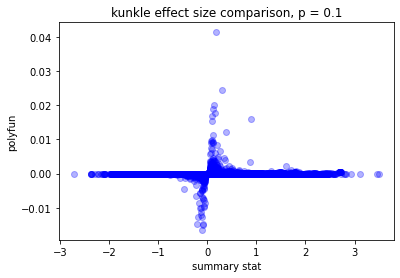

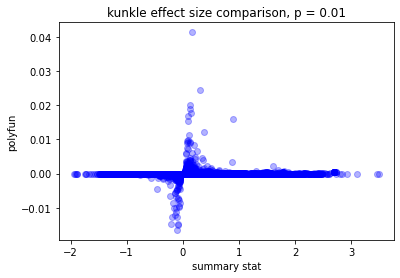

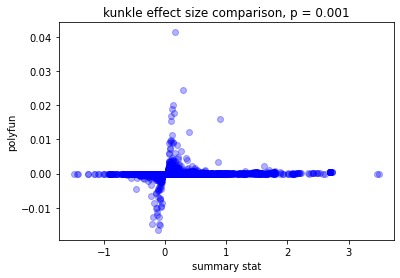

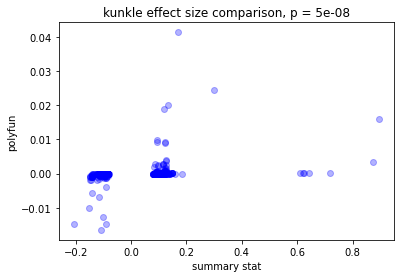

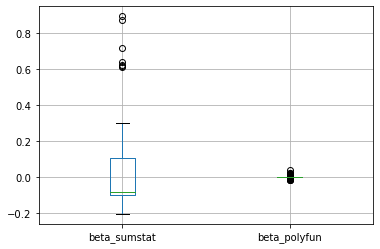

In [10]:
plot_beta(merge_kunkle, 'kunkle')

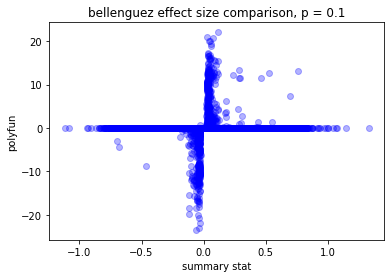

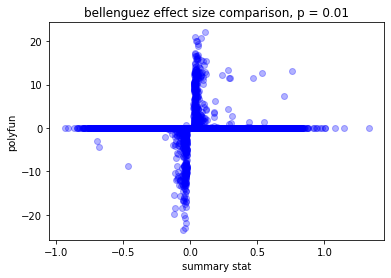

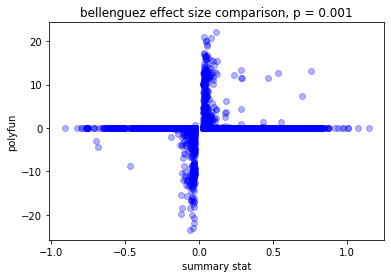

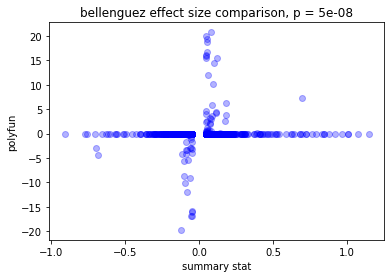

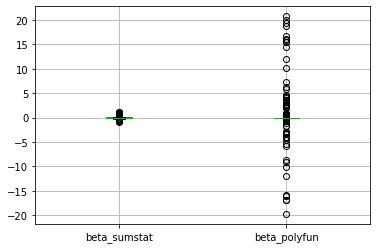

In [12]:
plot_beta(merge_bellenguez,'bellenguez')

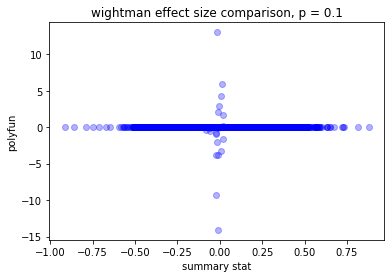

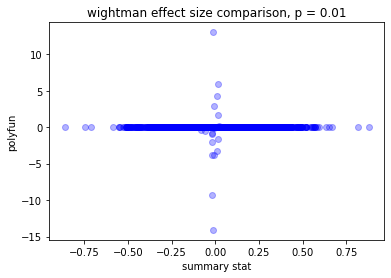

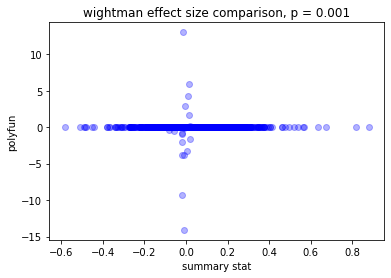

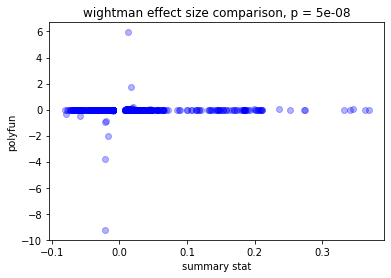

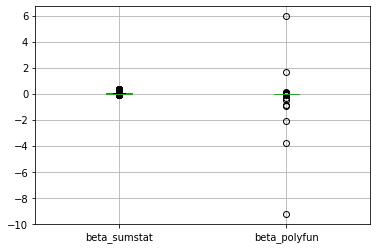

In [9]:
wightman_polyfun = pd.read_csv('/gpfs/commons/home/tlin/output/wightman/wightman_fixed_0224/finemap/max_snp_10/agg_fixed_converge.tsv', sep = '\t', usecols = ['SNP','PIP','BETA_MEAN'])
merge_wightman =  merge_beta(wightman_new ,wightman_polyfun)
plot_beta(merge_wightman,'wightman')

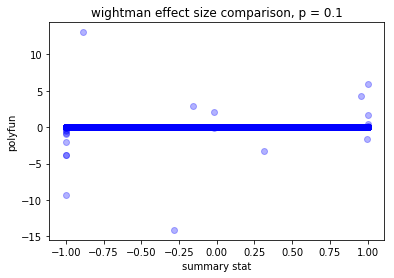

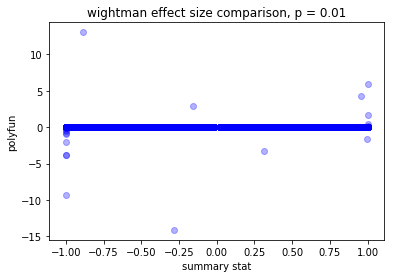

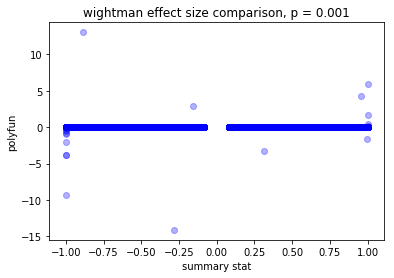

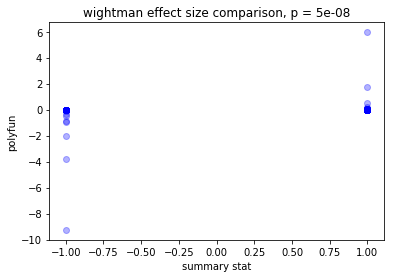

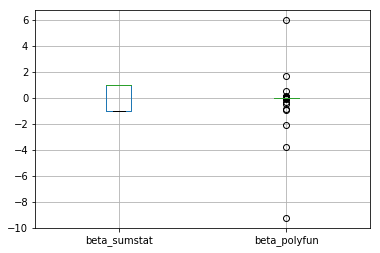

In [89]:
plot_beta(merge_wightman,'wightman')

## check if the beta that was shrinkaged to 0 in polyfun was in high LD with those in the middle (causal effect)

In [213]:
def check_PIP(df):
    upper = df.beta_sumstat.mean() + 2 * df.beta_sumstat.std()
    lower = df.beta_sumstat.mean() - 2 * df.beta_sumstat.std()
    two_sd_outer = df[(df.beta_sumstat <= lower) | (df.beta_sumstat >= upper)]
    print(' There are %d variants whose summary stat beta are >= 2SD' %(two_sd_outer.shape[0]))
    two_sd_outer = two_sd_outer[df.beta_polyfun == 0]
    print(' And out of %d of them has zero effect size calculated by polyfun'%(two_sd_outer.shape[0]))
    return (two_sd_outer)



def middle_SNP(df,chr):
    upper = df.beta_polyfun.mean() +  df.beta_polyfun.std()
    lower = df.beta_polyfun.mean() -  df.beta_polyfun.std()
    middle = df[(df.beta_polyfun > lower) & (df.beta_polyfun < upper) &(df.CHR == chr)]
    print(' %d variants betas lie in 1SD within polyfun beta mean' %(middle.shape[0]))
    return (middle)


In [214]:
def get_nearest_effect_snp(df, chr_num):
    print("Getting the neaerest effect SNP in chr %d....."%(chr_num))
    ##get the middle ones and the outliears
    outer_sumstat_beta = check_PIP(df) ## get 2SD outer
    CHR = outer_sumstat_beta[(outer_sumstat_beta.beta_polyfun == 0) & (outer_sumstat_beta.CHR==chr_num)].reset_index() ## get 2SD outer where polyfun predicts the beta = 0 (SNP that has large beta in sumstat but small beta in polyfunå)
    middle_CHR = middle_SNP(df, chr_num)
    #middle_CHR = df[(df.CHR ==chr_num ) & (~df.BP.isin(CHR.BP))].reset_index()  ## get those around
    count = 0
    inconsistent = pd.DataFrame()
    for i in range(0,CHR.shape[0]): 
    #for i in range(0,2):
        #print(np.unique(abs(middle_CHR.BP - CHR.BP[i]).values).shape)
        #print(abs(middle_CHR.BP - CHR.BP[i]).nunique())
        index = abs(middle_CHR.BP - CHR.BP[i]).nsmallest(50).index.values.tolist()
        max_PIP = max(middle_CHR.loc[index].PIP)
        max_index = middle_CHR.loc[index].PIP.idxmax()
        if(max_PIP > 0):
            count +=1
            BP_Distance = abs(middle_CHR.loc[max_index,'BP'] - CHR.BP[i])
            add_row = middle_CHR.loc[max_index,:].append(pd.Series({"BP_distance":BP_Distance, "BP_effect":middle_CHR.loc[max_index,'BP']}))
            inconsistent = inconsistent.append(add_row, ignore_index = True)
    if (count > 0):
        print('%d variants in the middle 1SD has PIP > 0'%count)
        return(inconsistent)
        

In [236]:
def get_interested_variant(df, chr_start = 1, chr_end = 22):
    check_variant = pd.DataFrame()
    all_variant = np.empty(0)
    for chr in range(chr_start,chr_end+1):
        df = get_nearest_effect_snp(merge_wightman, chr)
        all_variant = np.append(all_variant,test.SNP)
        interested_variant = df[df.PIP>0.01]
        if(interested_variant.shape[0] > 0):
            check_variant = check_variant.append(interested_variant, ignore_index = True)
            print('%d variants in the middle 1SD has PIP > 0.01'% interested_variant.shape[0])
        print()
    return(check_variant, all_variant)

In [237]:
check_wightman = get_interested_variant(merge_wightman, chr_start=21)

Getting the neaerest effect SNP in chr 21.....
 There are 412139 variants whose summary stat beta are >= 2SD
 And out of 232457 of them has zero effect size calculated by polyfun


/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 125745 variants betas lie in 1SD within polyfun beta mean
4 variants in the middle 1SD has PIP > 0

Getting the neaerest effect SNP in chr 22.....
 There are 412139 variants whose summary stat beta are >= 2SD
 And out of 232457 of them has zero effect size calculated by polyfun


/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 127589 variants betas lie in 1SD within polyfun beta mean
10 variants in the middle 1SD has PIP > 0



In [241]:
merge_wightman[merge_wightman.SNP.isin(check_wightman[1])]


,SNP,CHR,BP,A1,A2,Z,P,N,MAF,beta_sumstat,PIP,beta_polyfun
8709904,rs6117404,20,126614,T,C,-1.764508,0.077647,721545,0.452008,-0.002951,0.000981,-0.000005
8709994,rs7264822,20,144551,G,T,-1.571646,0.116033,760574,0.030710,-0.007386,0.000791,-0.000003
8711157,rs6051725,20,382559,T,C,-1.762958,0.077908,723362,0.117524,-0.004551,0.000783,-0.000003
8711193,rs6139113,20,392283,C,T,3.639160,0.000274,724650,0.131809,0.008936,0.022398,0.000214
8713489,rs6039167,20,898271,G,A,2.317615,0.020470,716284,0.072928,0.007447,0.002207,0.000014
8713491,rs6055833,20,898549,T,G,1.543110,0.122804,743446,0.435283,0.002552,0.000718,0.000003
8713564,rs561548,20,918831,C,A,2.786174,0.005333,760333,0.156976,0.006211,0.005129,0.000039
8714015,rs6056706,20,1008465,G,A,-2.326939,0.019968,762103,0.194859,-0.004758,0.002049,-0.000013
8714095,rs6118727,20,1030235,A,G,3.029115,0.002453,761325,0.464922,0.004922,0.006967,0.000056
8714354,rs6514115,20,1116799,G,A,-2.243014,0.024896,762286,0.116825,-0.005655,0.001631,-0.000010


In [234]:
np.array(test.SNP)

array(['rs6051725', 'rs6039167', 'rs6079081', 'rs6105944', 'rs6135158',
       'rs202514', 'rs2422580', 'rs1810587', 'rs2008017', 'rs6118727',
       'rs2326084', 'rs6078473', 'rs6055833', 'rs6133034', 'rs202532',
       'rs6139113', 'rs549733', 'rs7264822', 'rs2422588', 'rs2422584',
       'rs202466', 'rs6056706', 'rs12625859', 'rs6514115', 'rs561548',
       'rs2422595', 'rs6139600', 'rs6117404', 'rs6116605', 'rs6074608'],
      dtype=object)

In [218]:
get_nearest_effect_snp(merge_wightman, 20)

Getting the neaerest effect SNP in chr 20.....
 There are 412139 variants whose summary stat beta are >= 2SD
 And out of 232457 of them has zero effect size calculated by polyfun


/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 207951 variants betas lie in 1SD within polyfun beta mean
19 variants in the middle 1SD has PIP > 0


,A1,A2,BP,BP_distance,BP_effect,CHR,MAF,N,P,PIP,SNP,Z,beta_polyfun,beta_sumstat
0,C,T,22004952.0,5514.0,22004952.0,20.0,0.012162,565282.0,0.131489,0.000099,rs189205273,1.508255,4.211700e-07,0.012940
1,C,A,23997439.0,4725.0,23997439.0,20.0,0.005534,82317.0,0.176781,0.000070,rs562529024,-1.350733,-2.672090e-07,-0.044829
2,C,A,23997439.0,4745.0,23997439.0,20.0,0.005534,82317.0,0.176781,0.000070,rs562529024,-1.350733,-2.672090e-07,-0.044829
3,G,A,30000119.0,5347.0,30000119.0,20.0,0.277133,762143.0,0.019965,0.000329,rs2076373,-2.327013,-2.493150e-06,-0.004211
4,G,A,30000119.0,5210.0,30000119.0,20.0,0.277133,762143.0,0.019965,0.000329,rs2076373,-2.327013,-2.493150e-06,-0.004211
5,G,T,32994337.0,8974.0,32994337.0,20.0,0.005579,428706.0,0.232946,0.000059,rs73257146,-1.192804,-2.283180e-07,-0.017293
6,C,T,32998605.0,10984.0,32998605.0,20.0,0.002893,8313.0,0.352409,0.000046,rs535835273,-0.929926,-1.390670e-07,-0.133094
7,C,T,32998605.0,12002.0,32998605.0,20.0,0.002893,8313.0,0.352409,0.000046,rs535835273,-0.929926,-1.390670e-07,-0.133094
8,T,C,32999753.0,11960.0,32999753.0,20.0,0.007899,72239.0,0.561179,0.000036,rs182212739,0.581091,6.882650e-08,0.017267
9,C,T,44991482.0,13702.0,44991482.0,20.0,0.080928,531229.0,0.016637,0.000045,rs2258508,-2.394622,-3.760410e-07,-0.008518


In [14]:
wightman_bl_max10 = pd.read_csv('/gpfs/commons/home/tlin/output/wightman/fixed_0224_annotations/bl/max_snp_10/aggregate.all.txt.gz',compression='gzip', sep = '\t')

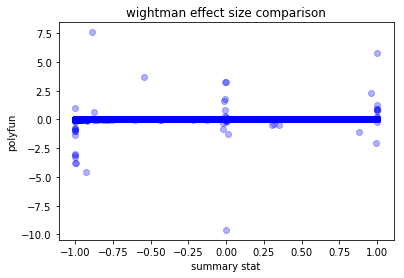

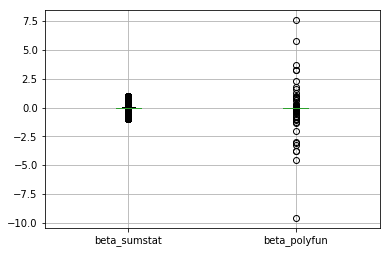

In [15]:
plot_beta(merge_beta(wightman, wightman_bl_max10) ,'wightman')  ## this one only has bl annotations. 